In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
from scipy.stats import ortho_group
import warnings
warnings.filterwarnings("ignore")
np.random.seed(4000)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

In [3]:
dim = 3

antisparse_dims = np.array([0,1])
nonnegative_dims = np.array([2])
relative_sparse_dims_list = [np.array([0,1]),np.array([1,2])]
(A,b), V = generate_practical_polytope(dim, antisparse_dims, nonnegative_dims, relative_sparse_dims_list)
S = generate_uniform_points_in_polytope(V, 500000)

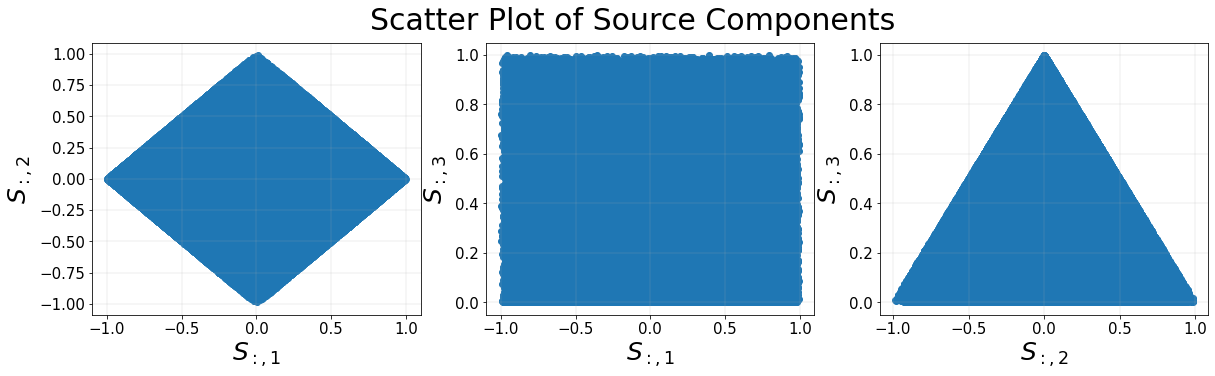

In [4]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.scatter(S[0,:], S[1,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,2}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,2)
plt.scatter(S[0,:], S[2,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,3)
plt.scatter(S[1,:], S[2,:])
plt.xlabel("$S_{:,2}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)

plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 200)

In [5]:
N = 500000
NumberofSources = 3
NumberofMixtures = 6

M = NumberofMixtures
r = NumberofSources
SNRlevel = 30 # dB
NoiseAmp = (10 ** (-SNRlevel/20))

INPUT_STD = 0.5
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# A = ortho_group.rvs(NumberofMixtures)
X = A @ S
for MM in range(A.shape[0]):
    stdx = np.std(X[MM,:])
    A[MM,:] = A[MM,:]/stdx * INPUT_STD
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNRlevel/20)*INPUT_STD
X=Xn+Noisecomp

SNRinp = 20*np.log10(np.std(Xn)/np.std(Noisecomp))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 32.23321109003842


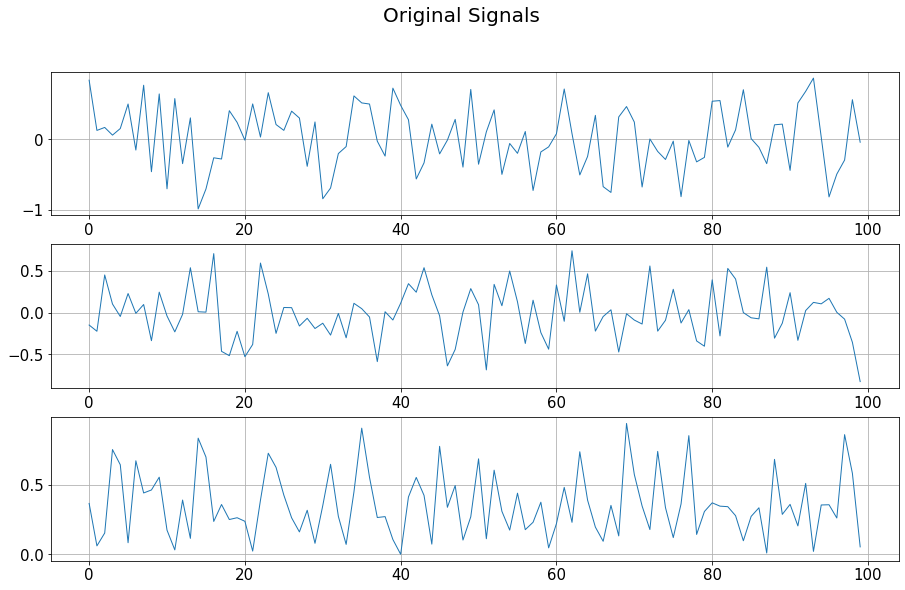

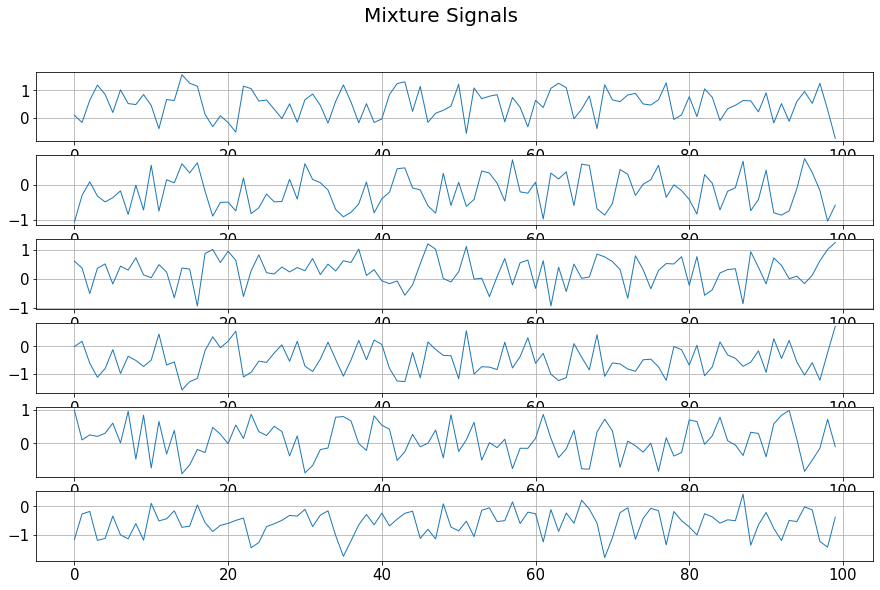

In [6]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,9), colorcode = None)

In [7]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [4,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1*1e-4
beta = 0.5
muD = [5.725, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

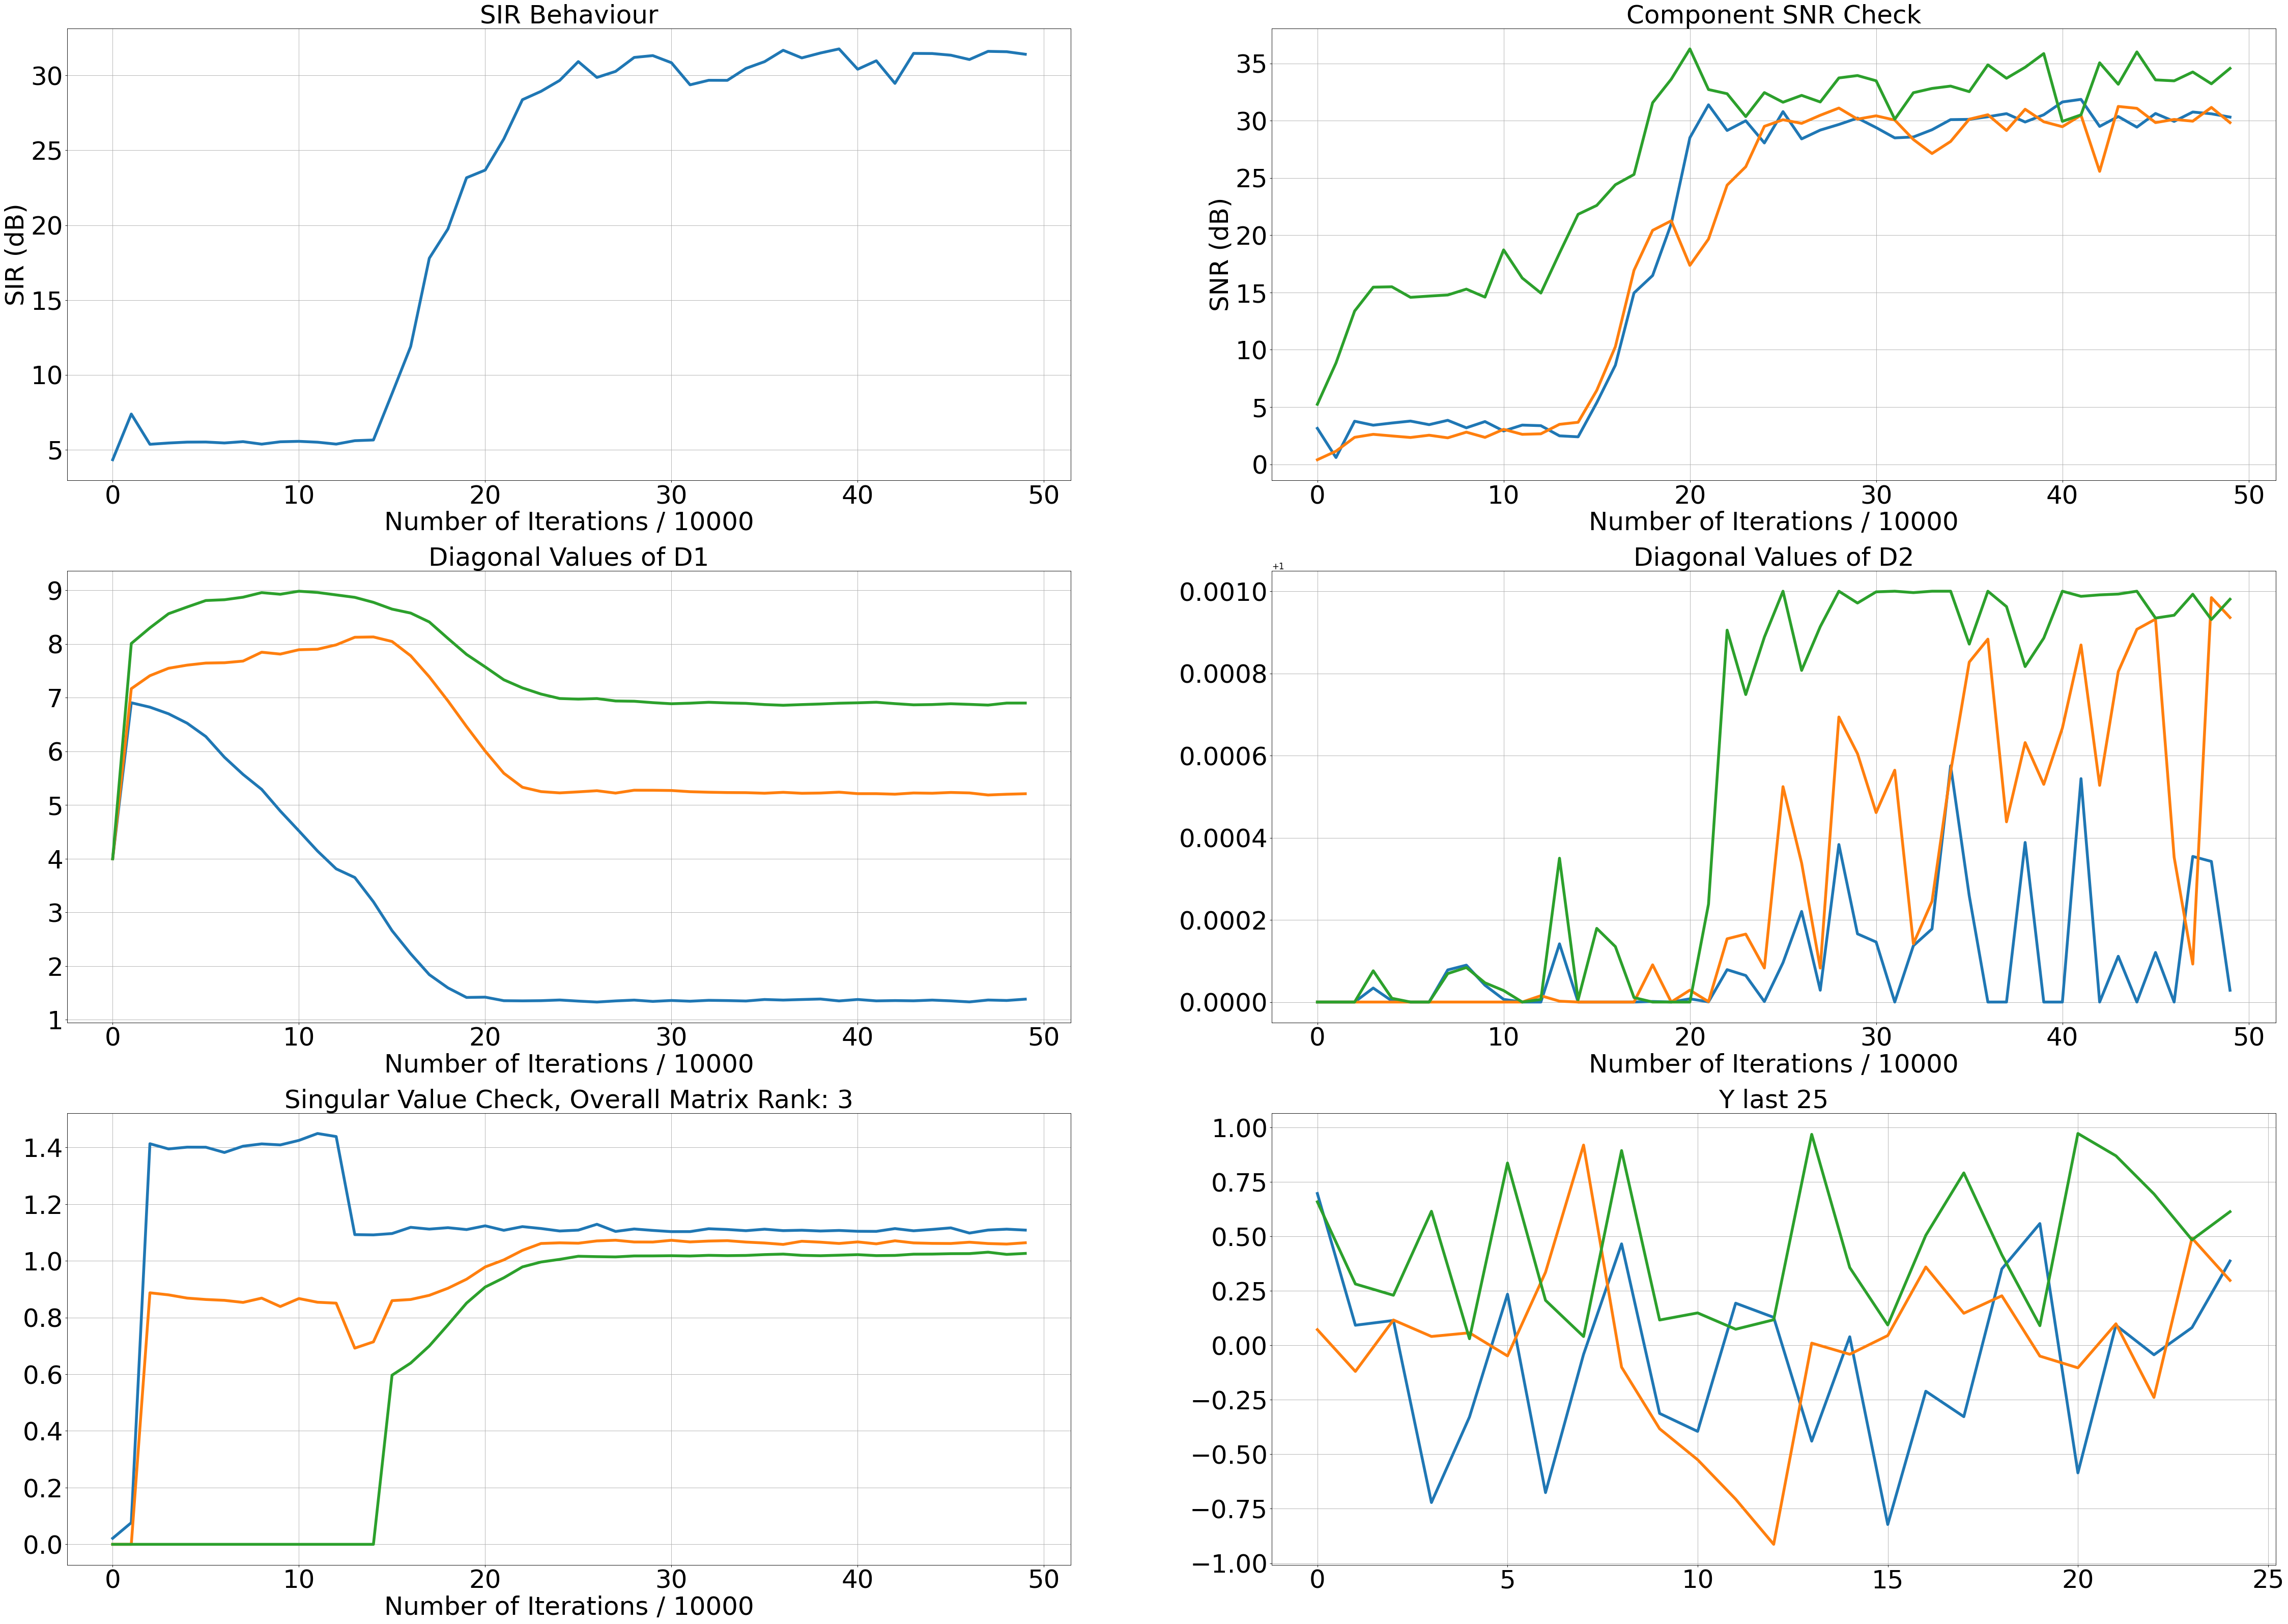

100%|██████████| 500000/500000 [1:08:09<00:00, 122.27it/s]


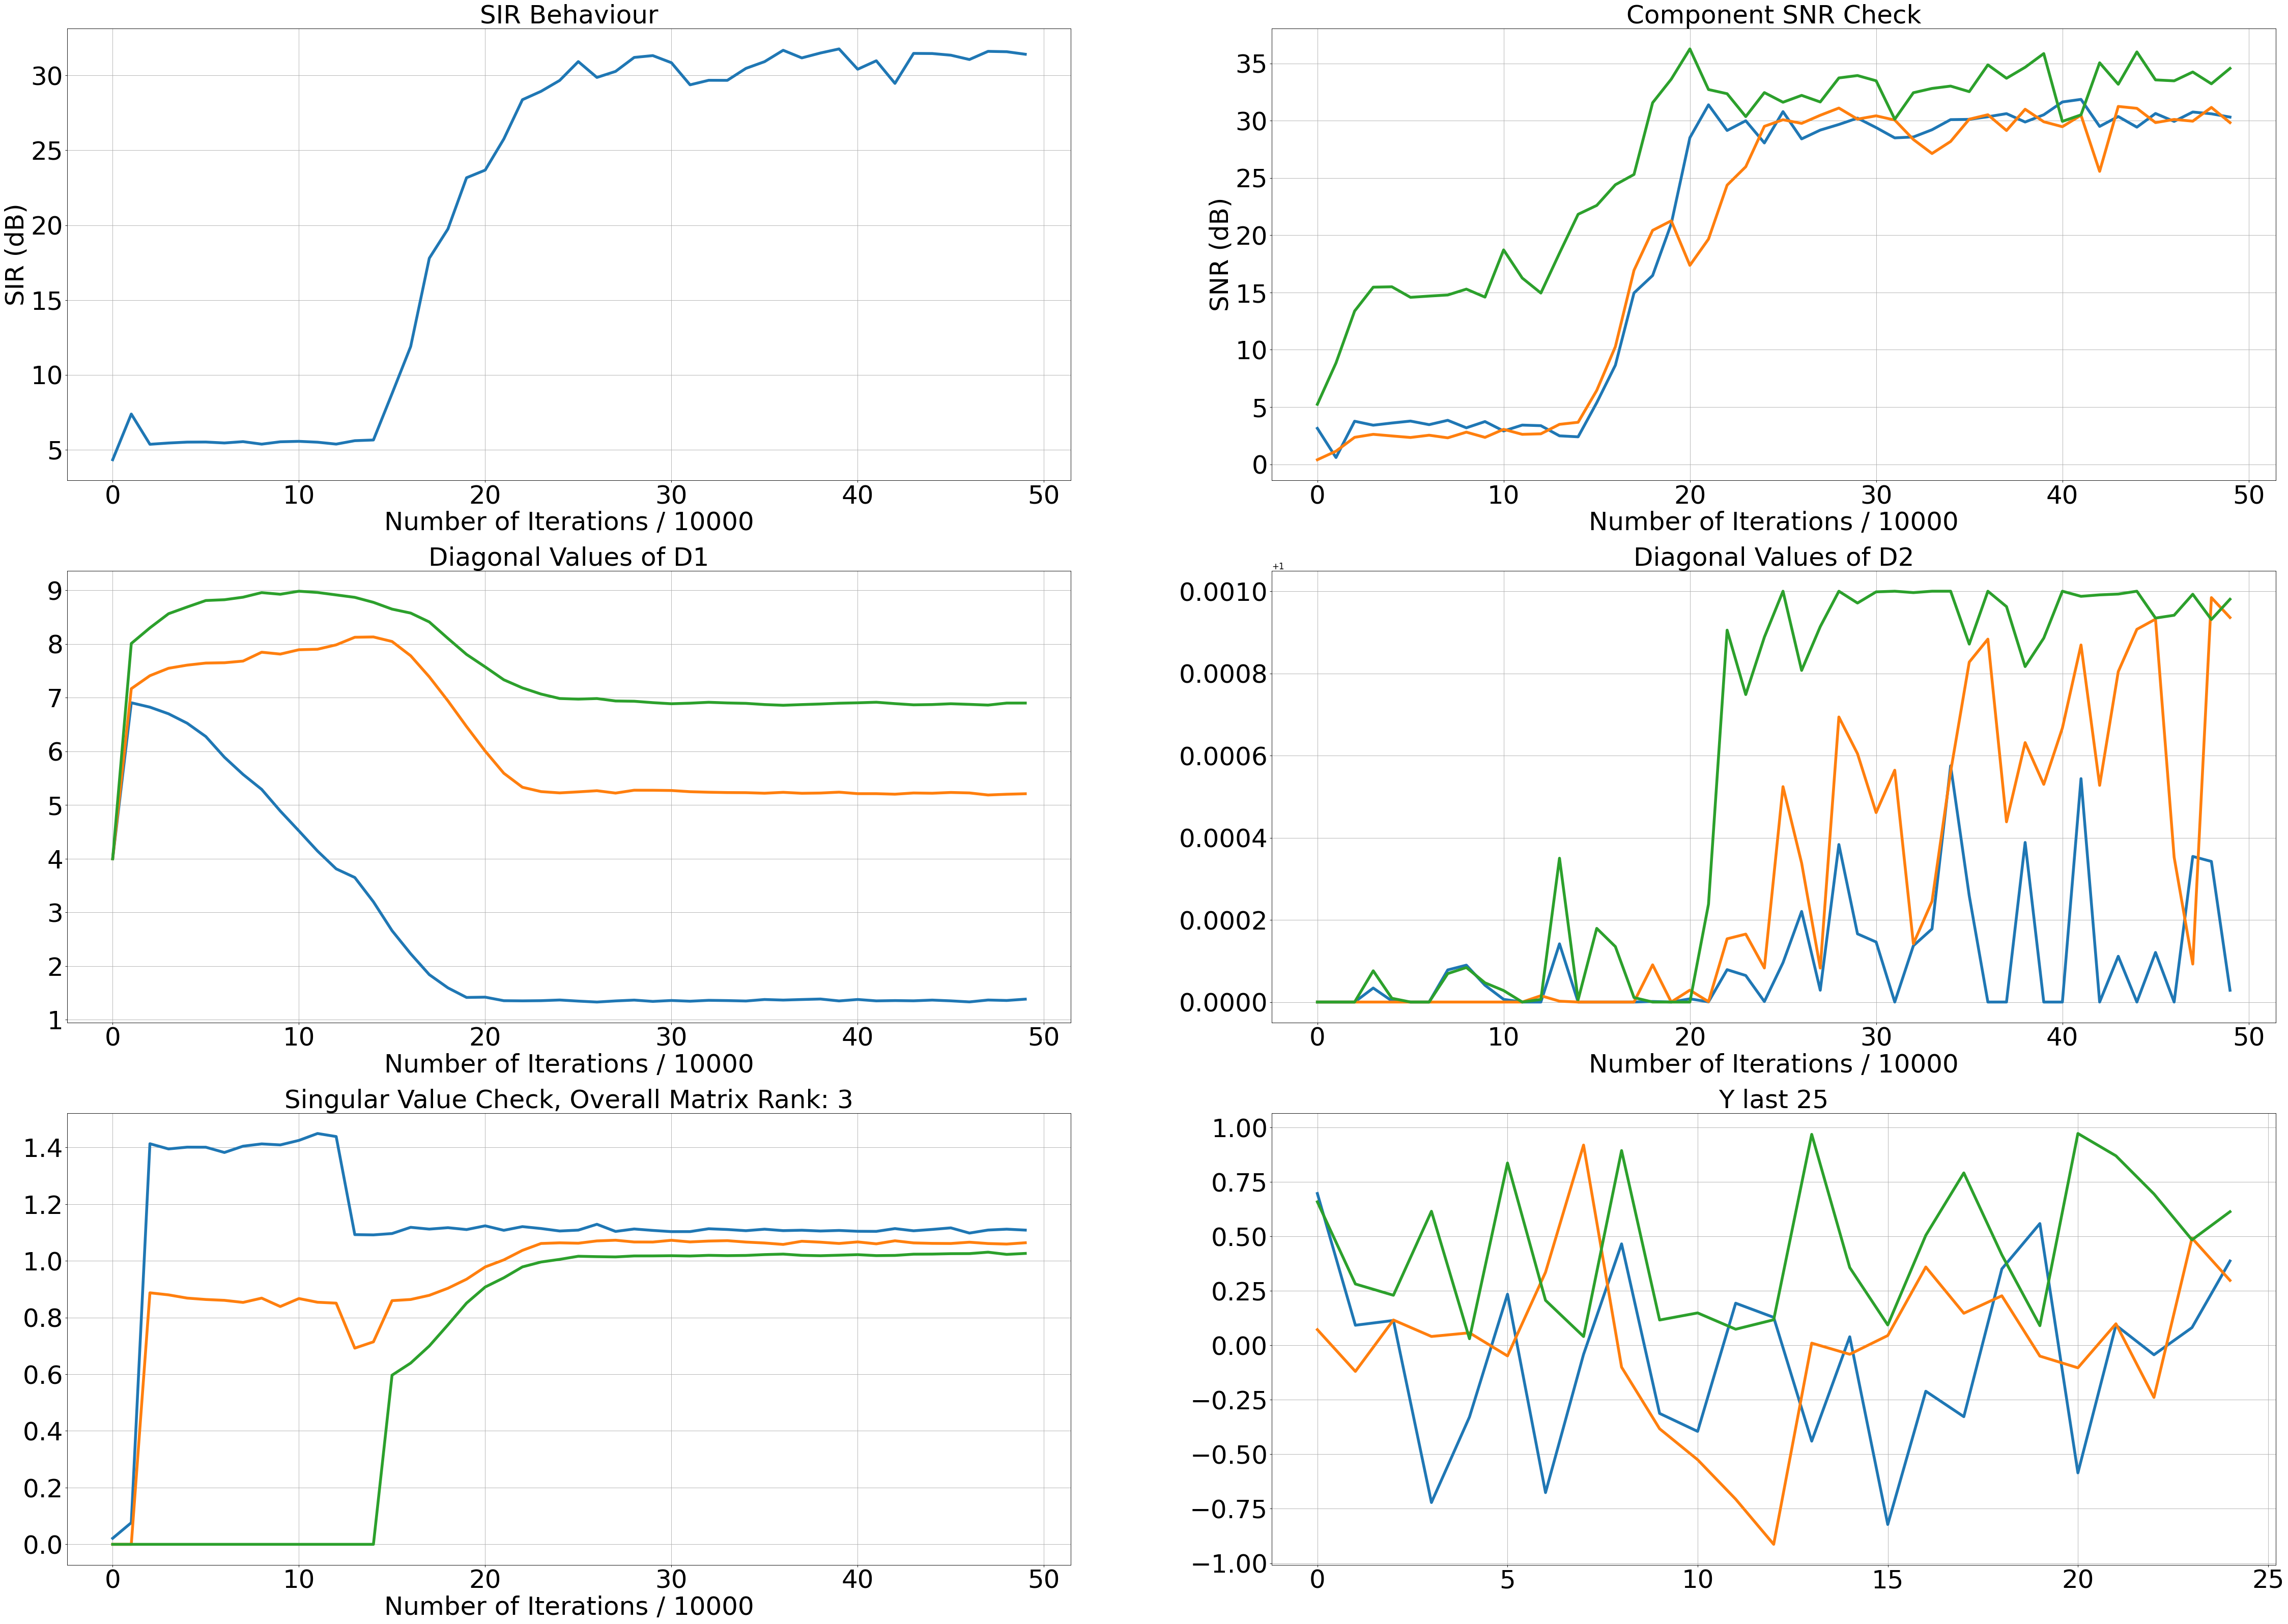

In [8]:
debug_iteration_point = 10000
modelWSM = OnlineWSMPMF(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = MUS, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_pmf(X, n_epochs = 1, 
                          neural_lr_start = 0.3,
                          debug_iteration_point = debug_iteration_point,
                          plot_in_jupyter = True,
                         )

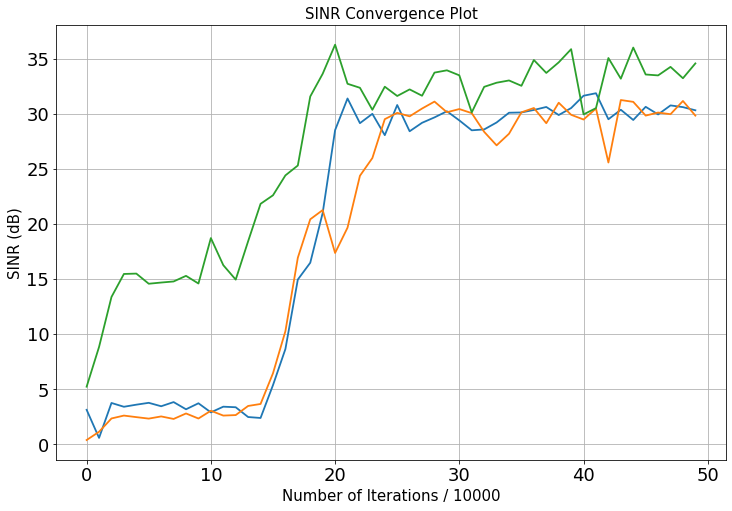

In [10]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

In [11]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [30.57035472 28.65925063 32.31283599]

Overall SINR : 31.432126675913445


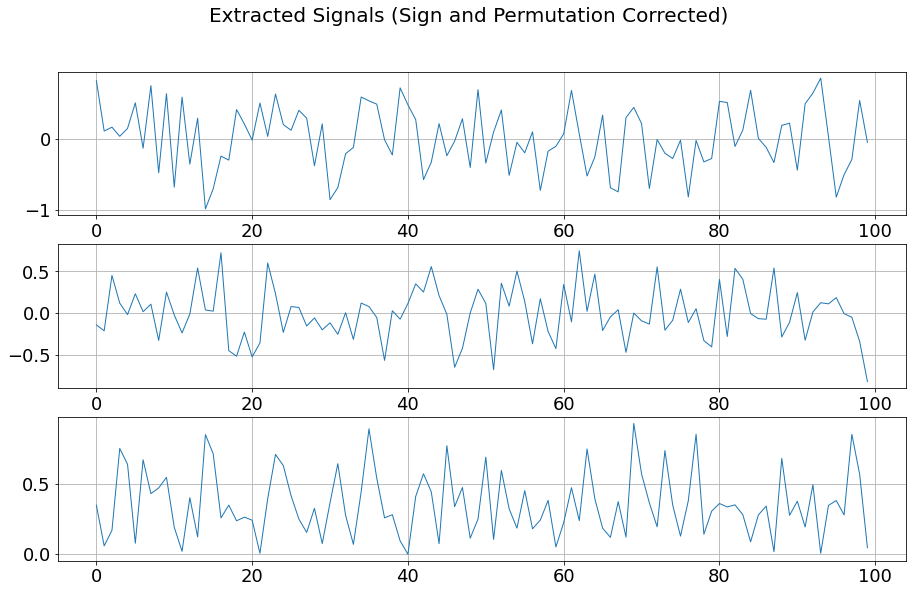

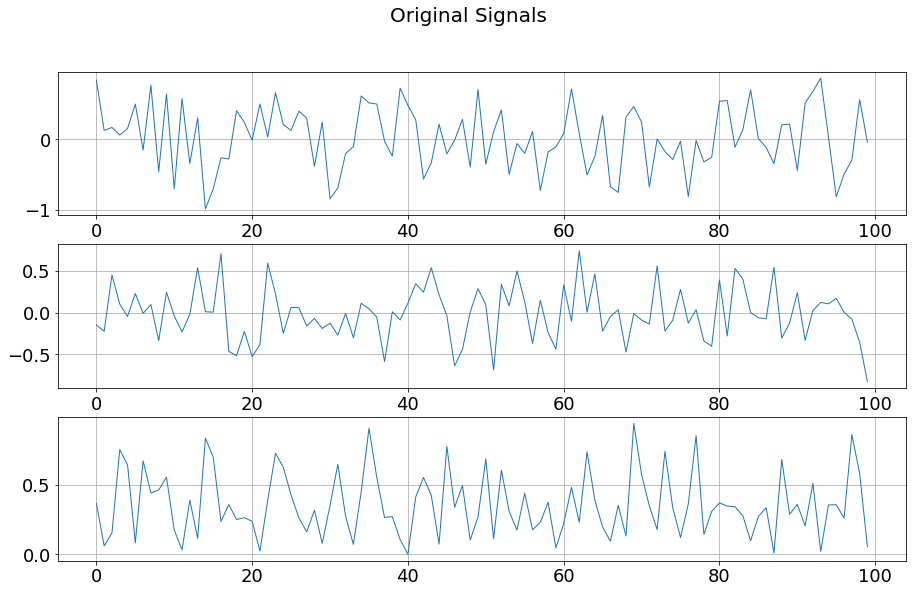

In [12]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)